# COQ4
todo

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.7.1


# COQ4
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for COQ4.

In [2]:
gene_symbol = 'COQ4'
mane_tx_id = 'NM_016035.5'
mane_protein_id = 'NP_057119.3' # ubiquinone biosynthesis protein COQ4 homolog, mitochondrial isoform 1 precursor [Homo sapiens]

In [3]:
from pyphetools.visualization import PhenopacketIngestor
pp_dir = '/Users/robin/GIT/phenopacket-store/notebooks/COQ4/phenopackets'
ingestor = PhenopacketIngestor(indir=pp_dir)
phenopackets = ingestor.get_phenopacket_list()

print(f'Loaded {len(phenopackets)} phenopackets')

[pyphetools] Ingested 51 GA4GH phenopackets.
Loaded 51 phenopackets


In [7]:
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets, load_phenopacket_folder

cohort_creator = configure_caching_cohort_creator(hpo)
"""
cohort, qc_results = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
"""
ppf = "../../../phenopacket-store/notebooks/COQ4/phenopackets"
cohort, qc_results = load_phenopacket_folder(ppf, cohort_creator)
qc_results.summarize()

Individuals Processed: 51individuals [00:00, 717.99individuals/s]
Validated under permissive policy
No errors or warnings were found


In [9]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Increased serum lactate,HP:0002151,23
Hypotonia,HP:0001252,17
Lower limb hyperreflexia,HP:0002395,14
Global developmental delay,HP:0001263,14
Seizure,HP:0001250,13
Lower limb spasticity,HP:0002061,12
Babinski sign,HP:0003487,12
Respiratory insufficiency,HP:0002093,11
Cerebellar hypoplasia,HP:0001321,11
Cerebellar atrophy,HP:0001272,10


# Domains
Note that according to UniProt Q9Y3A0 (Ubiquinone biosynthesis protein COQ4 homolog, mitochondrial) there are no protein domains to display so we show only the location of the variants. For this reason we create an empty dataframe

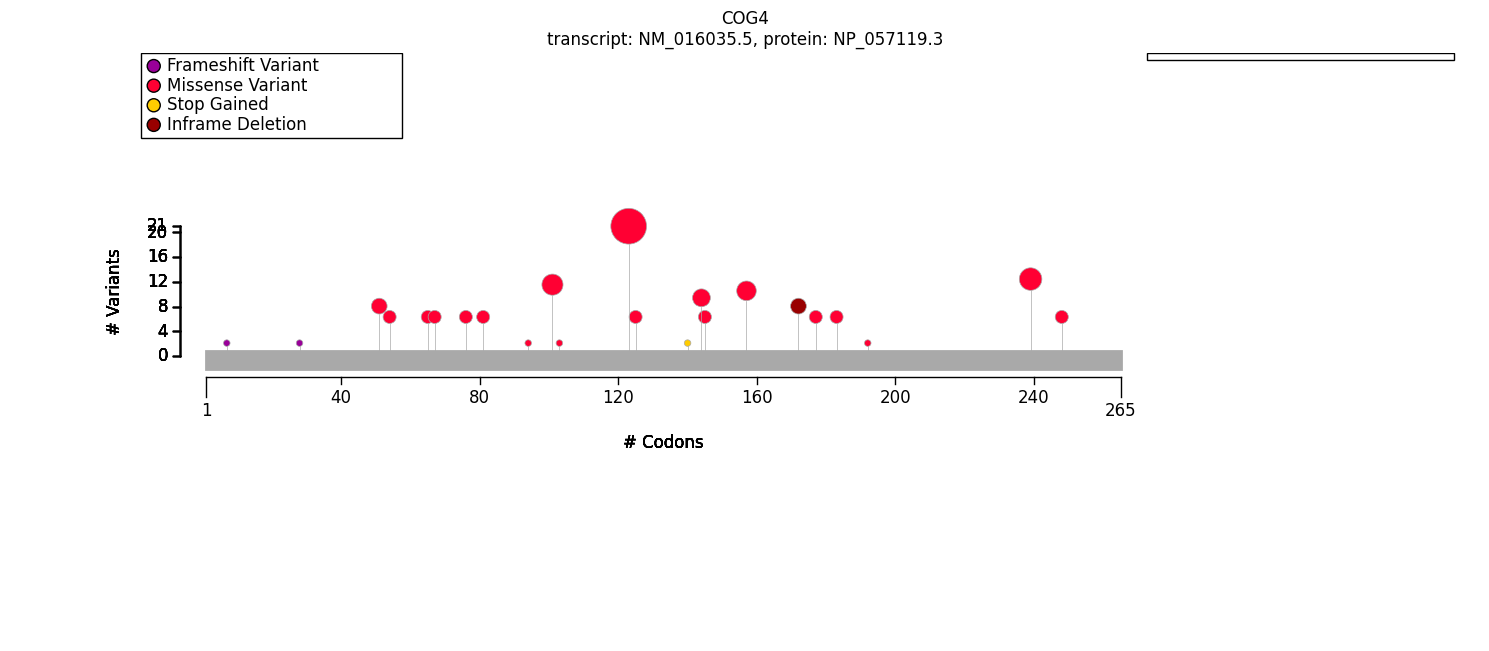

In [20]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
import pandas as pd
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id)
features = []
df = pd.DataFrame(features, columns=["region","category","start", "end"])
protein_meta = ProteinMetadata.from_feature_frame(protein_id=mane_protein_id, label="COG4", features=df, protein_length=265)


COG4_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
COG4_fig.tight_layout()

In [12]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [15]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, biallelic_predicate

is_missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id)
missense_predicate = biallelic_predicate(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label="missense", 
    b_label="other",
    partitions=((1,0),(2,))
)
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,24
HMF05,Skipping term because one genotype had zero observations,9
HMF08,Skipping general term,69
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,175


In [16]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       missense/other OR missense/missense  \
                                                                                 Count   
Cerebellar atrophy [HP:0001272]                                                   8/26   
Lower limb spasticity [HP:0002061]                                               14/22   
Morphological central nervous system abnormalit...                               27/27   
Abnormal brain morphology [HP:0012443]                                           26/26   

Allele group                                               other/other  \
                                                   Percent       Count   
Cerebellar atrophy [HP:0001272]                        31%         2/2   
Lower limb spasticity [HP:0002061]                     64%         0/2   
Morphological central nervous system abnormalit...    100%         2/2   
Abnormal brain morphology [HP:0012443]                100%         2/2   

Allele group                                                                   \
                                                   Percent Corrected p values   
Cerebellar atrophy [HP:0001272]                       100%           0.326087   
Lower limb spasticity [HP:0002061]                      0%           0.326087   
Morphological central nervous system abnormalit...    100%           1.000000   
Abnormal brain morphology [HP:0012443]                100%           1.000000   

Allele group                                                  
                                                    p values  
Cerebellar atrophy [HP:0001272]                     0.119048  
Lower limb spasticity [HP:0002061]                  0.163043  
Morphological central nervous system abnormalit...  1.000000  
Abnormal brain morphology [HP:0012443]              1.000000

In [17]:
is_g124s = VariantPredicates.variant_key("9_128325849_128325849_G_A") # c.370G>A	p.Gly124Ser
g124_predicate = biallelic_predicate(
    a_predicate=is_g124s,
    b_predicate=~is_g124s,
    a_label="G124S",
    b_label= "other",
    partitions=((1,0),(2,))
)
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=g124_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                                       G124S/other OR G124S/G124S  \
                                                                        Count   
Increased serum lactate [HP:0002151]                                    12/13   
Spasticity [HP:0001257]                                                  8/10   
Morphological central nervous system abnormalit...                        9/9   
Abnormal brain morphology [HP:0012443]                                    9/9   
Lower limb spasticity [HP:0002061]                                        4/6   
Appendicular spasticity [HP:0034353]                                      4/6   
Upper motor neuron dysfunction [HP:0002493]                               8/8   
Hypertonia [HP:0001276]                                                   8/8   
Abnormal muscle tone [HP:0003808]                                       15/15   
Hypotonia [HP:0001252]                                                   8/12   
Seizure [HP:0001250]                                                    11/13   
Acidosis [HP:0001941]                                                   12/12   

Allele group                                               other/other  \
                                                   Percent       Count   
Increased serum lactate [HP:0002151]                   92%       11/14   
Spasticity [HP:0001257]                                80%       12/17   
Morphological central nervous system abnormalit...    100%       20/20   
Abnormal brain morphology [HP:0012443]                100%       19/19   
Lower limb spasticity [HP:0002061]                     67%       10/18   
Appendicular spasticity [HP:0034353]                   67%       11/16   
Upper motor neuron dysfunction [HP:0002493]           100%       13/13   
Hypertonia [HP:0001276]                               100%       13/13   
Abnormal muscle tone [HP:0003808]                     100%       22/22   
Hypotonia [HP:0001252]                                 67%        9/13   
Seizure [HP:0001250]                                   85%       12/13   
Acidosis [HP:0001941]                                 100%       11/11   

Allele group                                                                   \
                                                   Percent Corrected p values   
Increased serum lactate [HP:0002151]                   79%                1.0   
Spasticity [HP:0001257]                                71%                1.0   
Morphological central nervous system abnormalit...    100%                1.0   
Abnormal brain morphology [HP:0012443]                100%                1.0   
Lower limb spasticity [HP:0002061]                     56%                1.0   
Appendicular spasticity [HP:0034353]                   69%                1.0   
Upper motor neuron dysfunction [HP:0002493]           100%                1.0   
Hypertonia [HP:0001276]                               100%                1.0   
Abnormal muscle tone [HP:0003808]                     100%                1.0   
Hypotonia [HP:0001252]                                 69%                1.0   
Seizure [HP:0001250]                                   92%                1.0   
Acidosis [HP:0001941]                                 100%                1.0   

Allele group                                                  
                                                    p values  
Increased serum lactate [HP:0002151]                0.595556  
Spasticity [HP:0001257]                             0.678389  
Morphological central nervous system abnormalit...  1.000000  
Abnormal brain morphology [HP:0012443]              1.000000  
Lower limb spasticity [HP:0002061]                  1.000000  
Appendicular spasticity [HP:0034353]                1.000000  
Upper motor neuron dysfunction [HP:0002493]         1.000000  
Hypertonia [HP:0001276]                             1.000000  
Abnormal muscle tone [HP:0003808]                   1.000000  


In [22]:
# Test both variants at position 240	

r240c = VariantPredicates.variant_key("9_128333565_128333565_C_T") # c.718C>T	p.Arg240Cys
r240h= VariantPredicates.variant_key("9_128333566_128333566_G_A") # c.719G>A	p.Arg240His
r240var = r240c | r240h

r124_predicate = biallelic_predicate(
    a_predicate=r240var,
    b_predicate=~r240var,
    a_label="G124S",
    b_label= "other",
    partitions=((1,0),(2,))
)
r124_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=r124_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=r124_result)

Allele group                                       G124S/other OR G124S/G124S  \
                                                                        Count   
Cerebellar atrophy [HP:0001272]                                           0/4   
Increased serum lactate [HP:0002151]                                      2/3   
Hypotonia [HP:0001252]                                                    3/3   
Spasticity [HP:0001257]                                                   3/5   
Morphological central nervous system abnormalit...                        4/4   
Abnormal brain morphology [HP:0012443]                                    4/4   
Lower limb spasticity [HP:0002061]                                        3/5   
Appendicular spasticity [HP:0034353]                                      3/5   
Upper motor neuron dysfunction [HP:0002493]                               3/3   
Hypertonia [HP:0001276]                                                   3/3   
Abnormal muscle tone [HP:0003808]                                         6/6   
Seizure [HP:0001250]                                                      2/2   
Acidosis [HP:0001941]                                                     2/2   

Allele group                                               other/other  \
                                                   Percent       Count   
Cerebellar atrophy [HP:0001272]                         0%       10/24   
Increased serum lactate [HP:0002151]                   67%       21/24   
Hypotonia [HP:0001252]                                100%       14/22   
Spasticity [HP:0001257]                                60%       17/22   
Morphological central nervous system abnormalit...    100%       25/25   
Abnormal brain morphology [HP:0012443]                100%       24/24   
Lower limb spasticity [HP:0002061]                     60%       11/19   
Appendicular spasticity [HP:0034353]                   60%       12/17   
Upper motor neuron dysfunction [HP:0002493]           100%       18/18   
Hypertonia [HP:0001276]                               100%       18/18   
Abnormal muscle tone [HP:0003808]                     100%       31/31   
Seizure [HP:0001250]                                  100%       21/24   
Acidosis [HP:0001941]                                 100%       21/21   

Allele group                                                                   \
                                                   Percent Corrected p values   
Cerebellar atrophy [HP:0001272]                        42%                1.0   
Increased serum lactate [HP:0002151]                   88%                1.0   
Hypotonia [HP:0001252]                                 64%                1.0   
Spasticity [HP:0001257]                                77%                1.0   
Morphological central nervous system abnormalit...    100%                1.0   
Abnormal brain morphology [HP:0012443]                100%                1.0   
Lower limb spasticity [HP:0002061]                     58%                1.0   
Appendicular spasticity [HP:0034353]                   71%                1.0   
Upper motor neuron dysfunction [HP:0002493]           100%                1.0   
Hypertonia [HP:0001276]                               100%                1.0   
Abnormal muscle tone [HP:0003808]                     100%                1.0   
Seizure [HP:0001250]                                   88%                1.0   
Acidosis [HP:0001941]                                 100%                1.0   

Allele group                                                  
                                                    p values  
Cerebellar atrophy [HP:0001272]                     0.265201  
Increased serum lactate [HP:0002151]                0.394530  
Hypotonia [HP:0001252]                              0.526957  
Spasticity [HP:0001257]                             0.579896  
Morphological central nervous system abnormalit...  1.000000  
Abnormal brain m